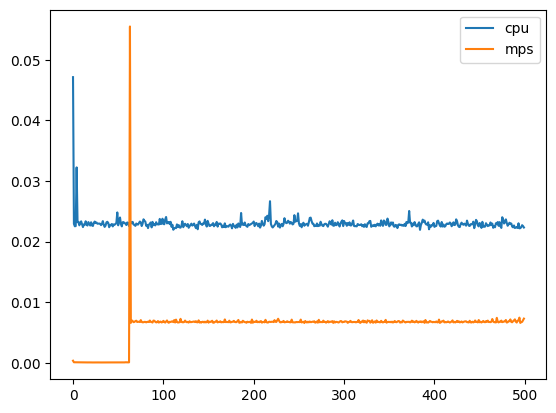

In [8]:
## Investigating if m1 speeds things up

import torch
import time
import matplotlib.pyplot as plt

cpu_device = torch.device('cpu')
mps_device = torch.device('mps')
hi_cpu = torch.rand((10000, 10000), dtype=torch.float32).to(cpu_device)
bye_cpu = torch.rand((10000, 10000), dtype=torch.float32).to(cpu_device)
hi_mps = torch.rand((10000, 10000), dtype=torch.float32).to(mps_device)
bye_mps = torch.rand((10000, 10000), dtype=torch.float32).to(mps_device)

ts_cpu = []
for i in range(500):
    t = time.perf_counter()
    hi_cpu * bye_cpu
    # print("dt: {}".format(time.perf_counter() - t))
    ts_cpu.append(time.perf_counter() - t)
plt.plot(ts_cpu, label='cpu')

ts_mps = []
for i in range(500):
    t = time.perf_counter()
    hi_mps * bye_mps
    # print("dt: {}".format(time.perf_counter() - t))
    ts_mps.append(time.perf_counter() - t)
plt.plot(ts_mps, label='mps')
plt.legend()

# Read data

In [24]:
names = open('compiled_names.txt', 'r').read().splitlines()

print(names[:5])
print(len(names))

['butterly', 'gawne', 'mouch', 'nicolaizeau', 'falson']
197029


In [25]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import wandb

In [26]:
device = torch.device("mps")

In [27]:
## functions to convert chars to int and inverse

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}

# . is both "before start" in X, and "im done" for Y
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

num_char = len(stoi)
# for s, i in stoi.items():
#     print("'{}' --> {} --> '{}'".format(s, stoi[s], itos[stoi[s]]))

In [28]:
window = 3

def build_dataset(words, device):
    x, y = [], []

    for word in words:
        for i, c in enumerate(word + '.'):
            mini_x = []
            for w in reversed(range(1, window+1)):
                if i - w >= 0:
                    mini_x.append(stoi[word[i-w]])
                else:
                    mini_x.append(stoi['.'])

            x.append(mini_x)
            y.append(stoi[c])
            
    return torch.tensor(x, device=device), torch.tensor(y, device=device)

# for i in range(len(y)): 
#     print("{} --> {}".format([itos[c] for c in x[i]], itos[y[i]]))
        
# x = torch.tensor(x, dtype=torch.int64)
# y = torch.tensor(y, dtype=torch.int64)

In [29]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1], device)
Xdev, Ydev = build_dataset(names[n1:n2], device)
Xte, Yte = build_dataset(names[n2:], device)

# Setup network

In [30]:
class MLP(nn.Module):
    def __init__(self, num_char, hidden_nodes, embeddings, window, num_layers):   
        super(MLP, self).__init__()
        
        self.window = window
        self.hidden_nodes = hidden_nodes
        self.embeddings = embeddings
        
        self.C = nn.Parameter(torch.randn((num_char, embeddings)) * 0.1, requires_grad=True)
        
        self.first = nn.Linear(embeddings*window, hidden_nodes)

        self.layers = nn.Sequential()
        for i in range(num_layers):
            self.layers = self.layers.extend(nn.Sequential(
                nn.Linear(hidden_nodes, hidden_nodes, bias=False),
                nn.BatchNorm1d(hidden_nodes),
                nn.Tanh()))

        self.final = nn.Linear(hidden_nodes, num_char)
        
    def forward(self, x):
        x = self.C[x]
        x = self.first(x.view(-1, self.window*self.embeddings))
        
        x = self.layers(x)

        x = self.final(x)
        return x


In [31]:
from torchinfo import summary
test_mlp = MLP(30, 100, 10, 3, 5)
test_mlp.to(device)
summary(test_mlp, input_size=(64, 3), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 30]                  300
├─Linear: 1-1                            [64, 100]                 3,100
├─Sequential: 1-2                        [64, 100]                 --
│    └─Linear: 2-1                       [64, 100]                 10,000
│    └─BatchNorm1d: 2-2                  [64, 100]                 200
│    └─Tanh: 2-3                         [64, 100]                 --
│    └─Linear: 2-4                       [64, 100]                 10,000
│    └─BatchNorm1d: 2-5                  [64, 100]                 200
│    └─Tanh: 2-6                         [64, 100]                 --
│    └─Linear: 2-7                       [64, 100]                 10,000
│    └─BatchNorm1d: 2-8                  [64, 100]                 200
│    └─Tanh: 2-9                         [64, 100]                 --
│    └─Linear: 2-10                      [64, 100]                

In [32]:
hidden_nodes = 200
embeddings = 10
num_layers = 10

mlp = MLP(num_char, hidden_nodes, embeddings, window, num_layers)
mlp.to(device)
mlp.train(mode=True)

steps = []
losses = []
dev_steps = []
dev_losses = []
batch_size = 64
max_steps = 100000
# max_steps = 1
start_time = time.perf_counter()

for i in range(max_steps+1):
    # sample from training set
    sample_idx = torch.randint(len(Ytr), size=(batch_size,1))
    
    # forward
    y_pred = mlp(Xtr[sample_idx])
    loss = F.cross_entropy(y_pred, torch.squeeze(Ytr[sample_idx]))
    
    # abs
    mlp.zero_grad()
    
    loss.backward()
    
    # set learning rate
    if i < 20000:
        lr = 0.1
    elif i < 40000:
        lr = 0.05
    elif i < 75000:
        lr = 0.01
    else:
        lr = 0.005
        
    # update
    with torch.no_grad():
        for p in mlp.parameters():
            p += -lr * p.grad
        
    steps.append(i)
    losses.append(loss.item())
    
    if i % 5000 == 0: # print every once in a while
        dev_loss = 0
        with torch.no_grad():
            dev_idx = torch.randint(len(Ydev), size=(batch_size,1))
            dev_loss = F.cross_entropy(mlp(Xdev[dev_idx]), 
                                       torch.squeeze(Ydev[dev_idx]))
            
        current_time = time.perf_counter()
        dt = current_time - start_time
        print(f'{i:7d}/{max_steps:7d}: dt: {dt:.2f} dev_loss: {dev_loss.item():.4f} loss: {loss.item():.4f}')
        
        dev_losses.append(dev_loss.item())
        dev_steps.append(i)

current_time = time.perf_counter()
dt = current_time - start_time
print("total training time: {}".format(dt))

      0/ 100000: dt: 0.06 dev_loss: 3.3725 loss: 3.4125
   5000/ 100000: dt: 128.06 dev_loss: 2.3307 loss: 2.3459


KeyboardInterrupt: 

In [21]:
import yaml

config = {"num_char": num_char,
          "hidden_nodes": hidden_nodes,
          "embeddings": embeddings,
          "window": window,
          "num_layers": num_layers,
          "stoi": stoi}

with open('torch_mlp_config.yaml', 'w') as file:
    yaml.dump(config, file)
    
print(open('torch_mlp_config.yaml').read())

embeddings: 10
hidden_nodes: 200
num_char: 30
num_layers: 10
stoi:
  ' ': 1
  '''': 2
  '-': 3
  .: 0
  a: 4
  b: 5
  c: 6
  d: 7
  e: 8
  f: 9
  g: 10
  h: 11
  i: 12
  j: 13
  k: 14
  l: 15
  m: 16
  n: 17
  o: 18
  p: 19
  q: 20
  r: 21
  s: 22
  t: 23
  u: 24
  v: 25
  w: 26
  x: 27
  y: 28
  z: 29
window: 3

{' ': 1, "'": 2, '-': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29, '.': 0}


In [23]:
# Need to save w/ cpu because spaces doesn't support device('mps')
torch.save(mlp.to(torch.device("cpu")).state_dict(), "mlp_weights.pt")

# Get ideal learning rate

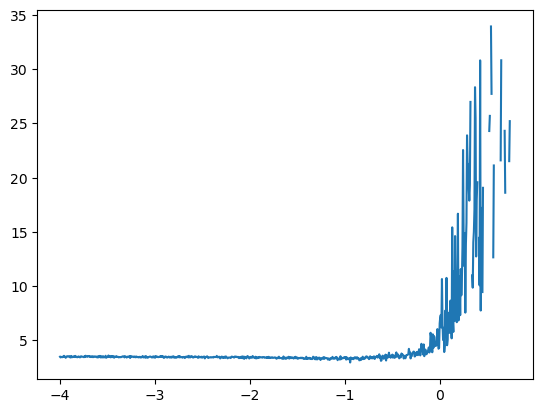

In [170]:
## test to get ideal learning rate
hidden_nodes = 200
embeddings = 10
num_layers = 10

mlp = MLP(num_char, hidden_nodes, embeddings, window, num_layers)
mlp.to(device)
mlp.train(mode=True)

lr_log = []
lre_log = []
loss_log = []
batch_size = 64
max_steps = 100000
# max_steps = 1
lres = torch.linspace(-4, 2, 1000)

for lre in reversed(lres):
    mlp = MLP(num_char, hidden_nodes, embeddings, window, num_layers)
    mlp.to(device)
    mlp.train(mode=True)
    lr = 10**lre
    for i in range(5):
        # sample from training set
        sample_idx = torch.randint(len(Ytr), size=(batch_size,1))

        # forward
        y_pred = mlp(Xtr[sample_idx])
        loss = F.cross_entropy(y_pred, torch.squeeze(Ytr[sample_idx]))

        # abs
        mlp.zero_grad()

        loss.backward()
        # update
        
        with torch.no_grad():
            for p in mlp.parameters():
                p += -lr * p.grad

    lr_log.append(lr.item())
    lre_log.append(lre.item())
    loss_log.append(loss.item())
    
plt.plot(lre_log, loss_log)

In [173]:
print(lre_log[:10])
print(loss_log[:10])

[2.0, 1.9939939975738525, 1.987987995147705, 1.9819819927215576, 1.9759759902954102, 1.9699699878692627, 1.9639639854431152, 1.9579579830169678, 1.9519519805908203, 1.9459459781646729]
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


In [33]:
plt.plot(torch.tensor(steps).view(-1, 200).mean(1), stepstorch.tensor(losses).view(-1, 200).mean(1), dev_steps, dev_losses)

RuntimeError: shape '[-1, 200]' is invalid for input of size 5553

In [ ]:
for p in mlp.parameters():
    y, x = torch.histogram(p.to(torch.device('cpu')), density=True)
    plt.plot(x[:-1].detach(), y.detach())

In [186]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * window # initialize with all ...
    out.append(stoi['c'])
    out.append(stoi['h'])
    out.append(stoi['e'])
    out.append(stoi['l'])
    out.append(stoi[' '])
    out.append(stoi['z'])
    context = context[1:] + [stoi['c']]
    context = context[1:] + [stoi['h']]
    context = context[1:] + [stoi['e']]
    context = context[1:] + [stoi['l']]
    context = context[1:] + [stoi[' ']]
    context = context[1:] + [stoi['z']]
    while True:
        mlp.eval()
        # mlp.train(mode=False)
        logits = mlp(context)
        mlp.train()
        # emb = C[torch.tensor([context])] # (1,block_size,d)
        # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        # logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

chel zone.
chel zodepuna.
chel zieler.
chel zakorner.
chel zuroney.
chel zudetzrot.
chel zul.
chel zan.
chel zier.
chel zacchud.
chel zakwailles.
chel zanemont.
chel zouilahous.
chel zavis.
chel zadaggfkin.
chel zan.
chel zowski.
chel zaigelbrin.
chel zoeckedeyon.
chel zmuno.


In [195]:
import gradio as gr

def generate_names(name_start, number_of_names):
    names = ""
    for _ in range((int)(number_of_names)):
    
        # Initialize name with user input
        name = ""
        context = [0] * window
        for c in name_start.lower():
            name += c
            context = context[1:] + [stoi[c]]

        # Run inference to finish off the name
        while True:
            mlp.eval()
            logits = mlp(context)
            mlp.train()

            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()

            context = context[1:] + [ix]
            name += itos[ix]
            if ix == 0:
                break
            
        names += name + "\n"
        
    return names

demo = gr.Interface(
    fn=generate_names,
    inputs=[
        gr.Textbox(placeholder="Start name with..."),
        "number"
    ],
    outputs="text",
)
demo.launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
